# **1) Environment Setup & Imports Library**


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from time import time

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Visual styling for plots
sns.set(style="whitegrid", context="talk")

# **2)  Data Loading & Initial Preprocessing**

In [4]:
def load_datasets():
    datasets = {}

    # 1. Human Activity Recognition (High-Dimensional)
    try:
        har_train = pd.read_csv('train.csv')
        har_test = pd.read_csv('test.csv')
        har_full = pd.concat([har_train, har_test], axis=0)

        # Assuming the last column is the label/target
        X_har = har_full.iloc[:, :-1]
        y_har = har_full.iloc[:, -1]

        # If labels are categorical/text, we encode them
        if y_har.dtype == 'object':
            le = LabelEncoder()
            y_har = le.fit_transform(y_har)

        datasets['HAR (High-Dim)'] = (X_har, y_har)
        print("HAR dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading HAR: {e}")

    # 2. Pima Indians Diabetes (Noisy/Low-Feature)
    try:
        diabetes = pd.read_csv('diabetes.csv')
        X_dia = diabetes.iloc[:, :-1]
        y_dia = diabetes.iloc[:, -1]

        # Professional trick: Replace 0s with NaN in biological columns (indicating missing values)
        # Values like Glucose or BloodPressure cannot be zero naturally.
        cols_with_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
        X_dia[cols_with_missing] = X_dia[cols_with_missing].replace(0, np.nan)

        datasets['Diabetes (Noisy)'] = (X_dia, y_dia)
        print("Diabetes dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading Diabetes: {e}")

    # 3. Bank Note Authentication (Non-Linear)
    try:
        bank = pd.read_csv('BankNoteAuthentication.csv')
        X_bank = bank.iloc[:, :-1]
        y_bank = bank.iloc[:, -1]
        datasets['Bank Note (Non-Linear)'] = (X_bank, y_bank)
        print("Bank Note dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading Bank Note: {e}")

    return datasets

data_collection = load_datasets()

HAR dataset loaded successfully.
Diabetes dataset loaded successfully.
Bank Note dataset loaded successfully.


# **3) Exploratory Data Analysis - EDA**

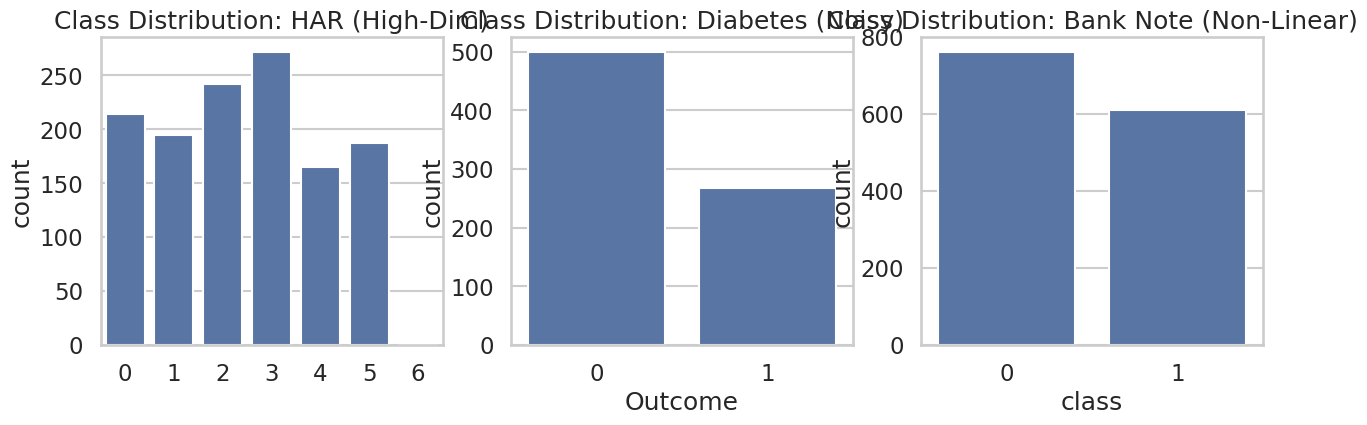

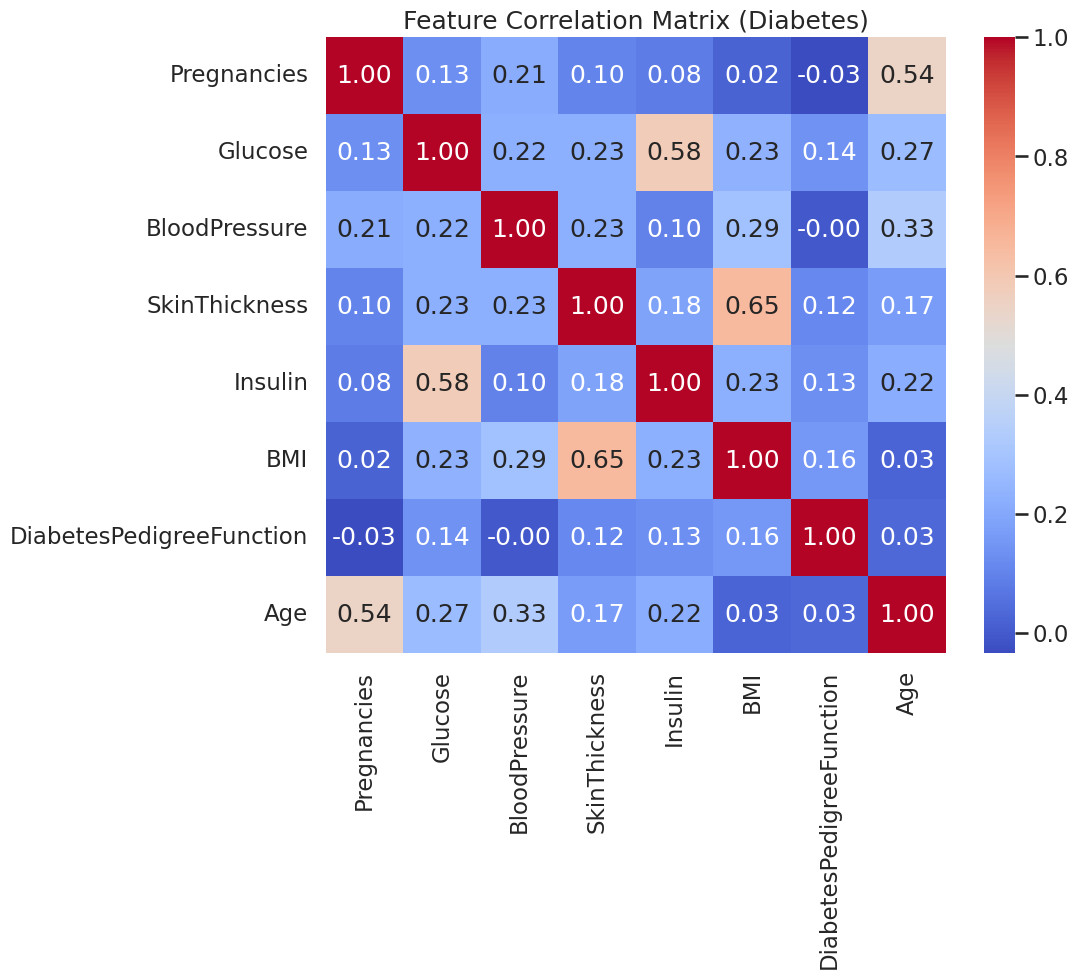

In [5]:
# Plot class distribution for each dataset (to check for class imbalance)
plt.figure(figsize=(15, 4))
for i, (name, (X, y)) in enumerate(data_collection.items()):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=y)
    plt.title(f"Class Distribution: {name}")
plt.show()

# Plot Correlation Matrix for Diabetes dataset (to check feature dependencies)
X_dia, _ = data_collection['Diabetes (Noisy)']
plt.figure(figsize=(10, 8))
sns.heatmap(X_dia.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix (Diabetes)")
plt.show()

# **4) Pipeline Construction & Model Configuration**

In [6]:
def get_model_pipeline(model_name, dataset_type):
    """
    Create a robust pipeline that handles missing data errors.
    """
    steps = []

    # Important Update: Add Imputer for ALL datasets (not just Diabetes)
    # This prevents "Input X contains NaN" errors in PCA or models.
    steps.append(('imputer', SimpleImputer(strategy='median')))

    # 2. Standardization
    steps.append(('scaler', StandardScaler()))

    # 3. Dimensionality Reduction (Specific to high-dimensional data and computationally expensive models)
    if dataset_type == 'HAR (High-Dim)' and model_name in ['kNN', 'SVM_rbf', 'SVM_poly']:
        steps.append(('pca', PCA(n_components=0.95)))

    # 4. Define model and hyperparameters
    if model_name == 'kNN':
        model = KNeighborsClassifier()
        params = {'model__n_neighbors': [3, 5, 7], 'model__metric': ['euclidean', 'manhattan']}

    elif model_name == 'LinearSVC':
        model = SVC(kernel='linear', probability=True)
        params = {'model__C': [0.1, 1, 10]}

    elif model_name == 'LogisticRegression':
        model = LogisticRegression(max_iter=1000)
        params = {'model__C': [0.1, 1, 10], 'model__solver': ['liblinear', 'lbfgs']}

    elif model_name == 'SVM_rbf':
        model = SVC(kernel='rbf', probability=True)
        params = {'model__C': [1, 10], 'model__gamma': ['scale', 0.1]}

    elif model_name == 'SVM_poly':
        model = SVC(kernel='poly', degree=3, probability=True)
        params = {'model__C': [1, 10]}

    elif model_name == 'DecisionTree':
        model = DecisionTreeClassifier()
        params = {'model__max_depth': [None, 5, 10], 'model__min_samples_split': [2, 5]}

    elif model_name == 'NaiveBayes':
        model = GaussianNB()
        params = {}

    elif model_name == 'MLP':
        model = MLPClassifier(max_iter=1000, early_stopping=True)
        params = {'model__hidden_layer_sizes': [(50,), (100, 50)], 'model__alpha': [0.0001, 0.001]}

    steps.append(('model', model))
    pipeline = Pipeline(steps)

    return pipeline, params

# **5) Main Experiment Loop & Model Evaluation**

In [7]:
results = []

for data_name, (X, y) in data_collection.items():
    print(f"\n{'='*20} Processing {data_name} {'='*20}")

    # Split data (Final Test set is completely isolated)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    models_to_run = ['kNN', 'LinearSVC', 'LogisticRegression', 'SVM_rbf', 'DecisionTree', 'NaiveBayes', 'MLP']

    for model_name in models_to_run:
        print(f"Training {model_name}...", end=" ")

        pipeline, params = get_model_pipeline(model_name, data_name)

        # Design Grid Search with Cross-Validation
        # We use StratifiedKFold to preserve class distribution in each fold
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid = GridSearchCV(pipeline, params, cv=cv, scoring='f1_weighted', n_jobs=-1)

        # Record training time
        start_train = time()
        grid.fit(X_train, y_train)
        train_time = time() - start_train

        # Best model selected
        best_model = grid.best_estimator_

        # Record prediction time
        start_pred = time()
        y_pred = best_model.predict(X_test)
        pred_time = time() - start_pred

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            'Dataset': data_name,
            'Model': model_name,
            'Best Params': grid.best_params_,
            'Accuracy': acc,
            'F1-Score': f1,
            'Train Time': train_time,
            'Pred Time': pred_time
        })
        print(f"Done. Acc: {acc:.4f}")

# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(results)
print("\nAnalysis Complete.")


==================== Processing HAR (High-Dim) ====================
Training kNN... Done. Acc: 0.9492
Training LinearSVC... Done. Acc: 0.9844
Training LogisticRegression... Done. Acc: 0.9961
Training SVM_rbf... Done. Acc: 0.9883
Training DecisionTree... Done. Acc: 0.9727
Training NaiveBayes... Done. Acc: 0.9180
Training MLP... Done. Acc: 0.9688

==================== Processing Diabetes (Noisy) ====================
Training kNN... Done. Acc: 0.7727
Training LinearSVC... Done. Acc: 0.7013
Training LogisticRegression... Done. Acc: 0.6948
Training SVM_rbf... Done. Acc: 0.7403
Training DecisionTree... Done. Acc: 0.7662
Training NaiveBayes... Done. Acc: 0.7013
Training MLP... Done. Acc: 0.7403

==================== Processing Bank Note (Non-Linear) ====================
Training kNN... Done. Acc: 1.0000
Training LinearSVC... Done. Acc: 0.9855
Training LogisticRegression... Done. Acc: 0.9855
Training SVM_rbf... Done. Acc: 1.0000
Training DecisionTree... Done. Acc: 0.9927
Training NaiveBayes..

# **6) Performance Visualization & Comparison**

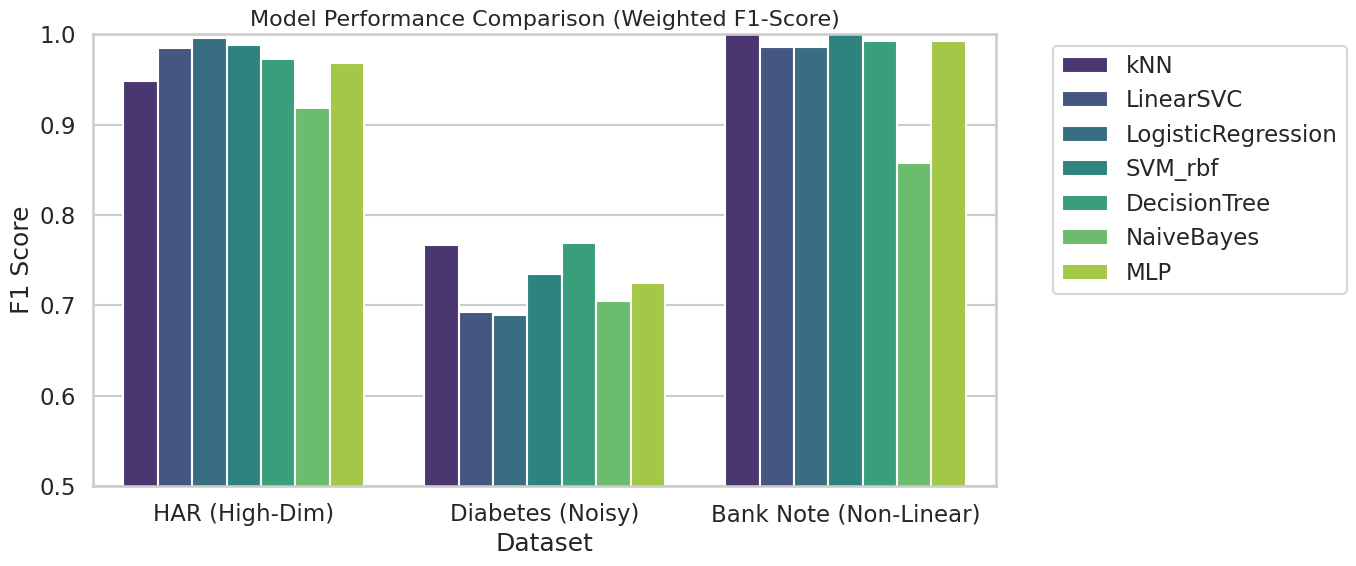

                   Dataset               Model  F1-Score  Train Time
2           HAR (High-Dim)  LogisticRegression  0.996088   10.245812
3           HAR (High-Dim)             SVM_rbf  0.988295   10.691822
1           HAR (High-Dim)           LinearSVC  0.984375    4.637176
4           HAR (High-Dim)        DecisionTree  0.972472    8.995358
6           HAR (High-Dim)                 MLP  0.968815    6.918123
0           HAR (High-Dim)                 kNN  0.948741    8.263394
5           HAR (High-Dim)          NaiveBayes  0.918256    0.422014
11        Diabetes (Noisy)        DecisionTree  0.768771    0.297478
7         Diabetes (Noisy)                 kNN  0.767290    0.434608
10        Diabetes (Noisy)             SVM_rbf  0.734865    0.876797
13        Diabetes (Noisy)                 MLP  0.725009    1.216801
12        Diabetes (Noisy)          NaiveBayes  0.704540    0.060362
8         Diabetes (Noisy)           LinearSVC  0.693171    0.973722
9         Diabetes (Noisy)  Logist

In [8]:
# Set plot dimensions
plt.figure(figsize=(14, 6))

# Plot F1-Score comparison using a bar chart
sns.barplot(data=df_results, x='Dataset', y='F1-Score', hue='Model', palette='viridis')
plt.title('Model Performance Comparison (Weighted F1-Score)', fontsize=16)

# Adjust legend position to be outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylabel('F1 Score')
plt.ylim(0.5, 1.0) # Zoom in on the relevant range (0.5 to 1.0) for better visibility
plt.tight_layout()
plt.show()

# Display sorted results table
print(df_results[['Dataset', 'Model', 'F1-Score', 'Train Time']].sort_values(by=['Dataset', 'F1-Score'], ascending=False))

# **7) Bias-Variance Analysis via Learning Curves**

Generating Learning Curve for MLP on HAR (This may take a moment)...


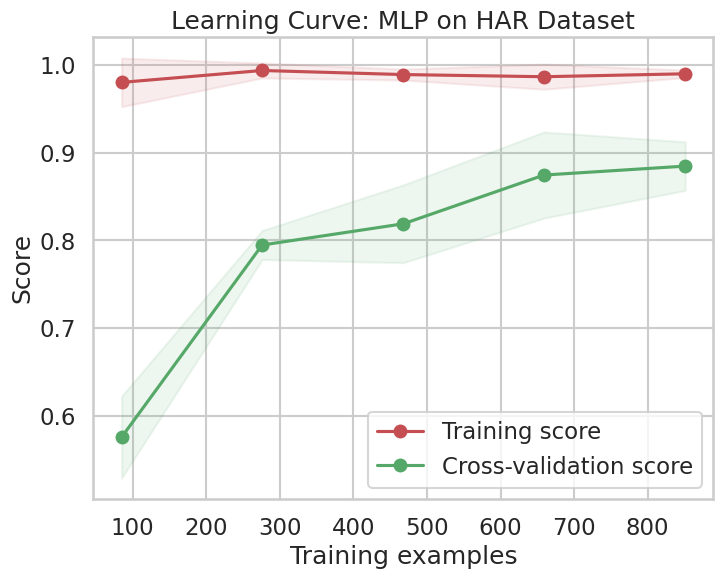

In [9]:
from sklearn.model_selection import learning_curve

def plot_learning_curve_for_analysis(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Plot variance range (standard deviation)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Generating Learning Curve for MLP on HAR dataset
# Note: Recreating pipeline since accessing best_estimator from the loop is complex in this context
print("Generating Learning Curve for MLP on HAR (This may take a moment)...")
pipeline_mlp, _ = get_model_pipeline('MLP', 'HAR (High-Dim)')
X_har, y_har = data_collection['HAR (High-Dim)']

# Plotting
plot_learning_curve_for_analysis(pipeline_mlp, X_har, y_har, "Learning Curve: MLP on HAR Dataset")

# **8) Decision Boundary Visualization: Linear vs. Non-Linear**

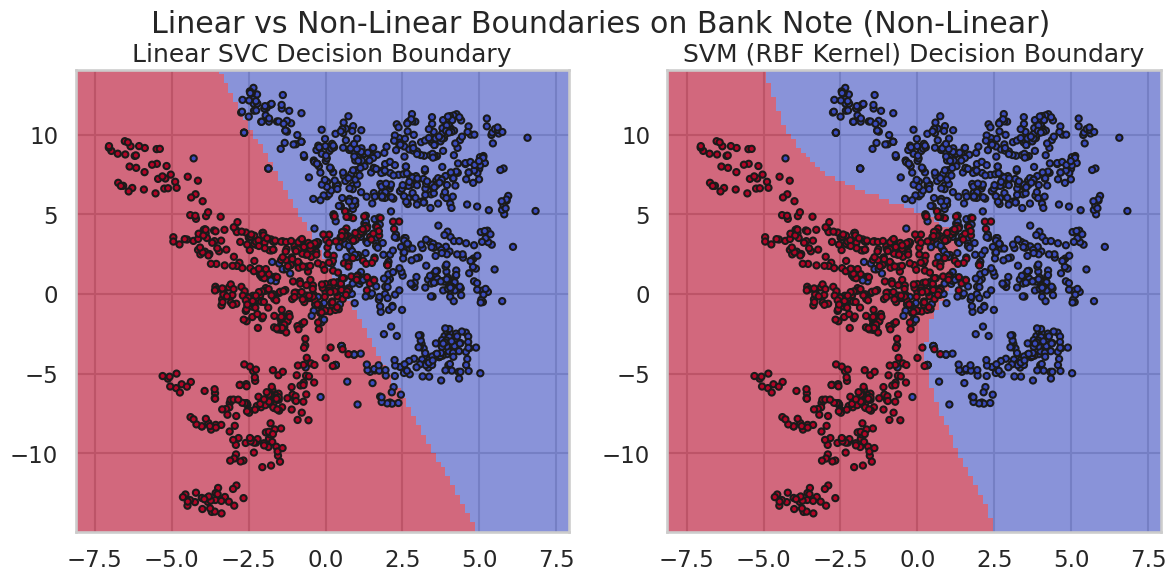

In [10]:
from sklearn.inspection import DecisionBoundaryDisplay

def visualize_boundaries(data_name, model_classes):
    X, y = data_collection[data_name]

    # Select only the first two features for visualization purposes
    # (Since we cannot plot 4D or 500D data on a 2D screen)
    X_2d = X.iloc[:, :2].values
    y_arr = y.values

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for i, (model_name, model_inst) in enumerate(model_classes.items()):
        # Train the model on the selected 2D features
        model_inst.fit(X_2d, y_arr)

        DecisionBoundaryDisplay.from_estimator(
            model_inst, X_2d, response_method="predict",
            cmap=plt.cm.coolwarm, plot_method="pcolormesh", shading="auto", alpha=0.6, ax=axes[i]
        )
        axes[i].scatter(X_2d[:, 0], X_2d[:, 1], c=y_arr, cmap=plt.cm.coolwarm, edgecolors="k", s=20)
        axes[i].set_title(f"{model_name} Decision Boundary")

    plt.suptitle(f"Linear vs Non-Linear Boundaries on {data_name}")
    plt.show()

# Compare Linear SVC vs. SVM with RBF Kernel on Bank Note dataset
models_comparison = {
    'Linear SVC': SVC(kernel='linear'),
    'SVM (RBF Kernel)': SVC(kernel='rbf')
}

visualize_boundaries('Bank Note (Non-Linear)', models_comparison)

# **9) Noise Robustness & Stability Analysis**

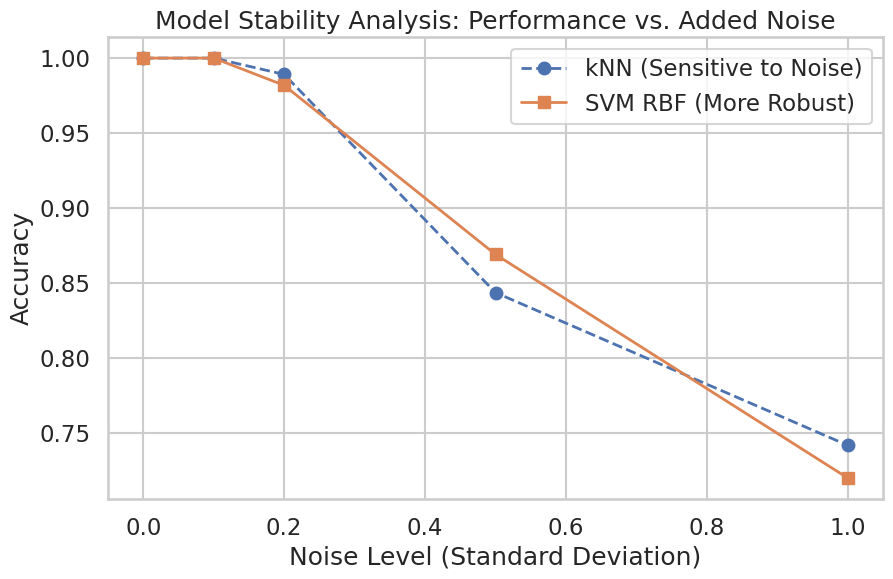

In [11]:
# New Section: Noise Robustness Analysis
def noise_robustness_test(model, X, y, noise_levels=[0, 0.1, 0.2, 0.5]):
    accuracies = []

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale data (Standardization is crucial before adding noise)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model on clean data
    model.fit(X_train_scaled, y_train)

    for noise in noise_levels:
        # Add Gaussian noise to the test set
        noise_matrix = np.random.normal(0, noise, X_test_scaled.shape)
        X_test_noisy = X_test_scaled + noise_matrix

        # Evaluate performance on noisy data
        acc = model.score(X_test_noisy, y_test)
        accuracies.append(acc)

    return accuracies

# Execute test on Bank Note dataset (due to its clear structure)
X_bank, y_bank = data_collection['Bank Note (Non-Linear)']
noise_levels = [0, 0.1, 0.2, 0.5, 1.0]

# Compare kNN (Sensitive) vs. SVM (Robust)
results_noise = {}
results_noise['kNN'] = noise_robustness_test(KNeighborsClassifier(n_neighbors=3), X_bank, y_bank, noise_levels)
results_noise['SVM (RBF)'] = noise_robustness_test(SVC(kernel='rbf'), X_bank, y_bank, noise_levels)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, results_noise['kNN'], 'o--', label='kNN (Sensitive to Noise)', linewidth=2)
plt.plot(noise_levels, results_noise['SVM (RBF)'], 's-', label='SVM RBF (More Robust)', linewidth=2)
plt.xlabel('Noise Level (Standard Deviation)')
plt.ylabel('Accuracy')
plt.title('Model Stability Analysis: Performance vs. Added Noise')
plt.legend()
plt.grid(True)
plt.show()